In [32]:
import pandas as pd
import glob
import pycountry
import pickle 
import re
from tqdm import tqdm
import gensim
import nltk
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from gensim import corpora
import spacy
import phrasemachine
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline

In [7]:
# # List of all bibtext files
file_list = glob.glob('bibtex_files/*/*.bib')
file_list

['bibtex_files/HESS/savedrecs-10.bib',
 'bibtex_files/HESS/savedrecs-11.bib',
 'bibtex_files/HESS/savedrecs-12.bib',
 'bibtex_files/HESS/savedrecs-2.bib',
 'bibtex_files/HESS/savedrecs-3.bib',
 'bibtex_files/HESS/savedrecs-4.bib',
 'bibtex_files/HESS/savedrecs-5.bib',
 'bibtex_files/HESS/savedrecs-6.bib',
 'bibtex_files/HESS/savedrecs-7.bib',
 'bibtex_files/HESS/savedrecs-8.bib',
 'bibtex_files/HESS/savedrecs-9.bib',
 'bibtex_files/HESS/savedrecs.bib',
 'bibtex_files/HP/savedrecs-10.bib',
 'bibtex_files/HP/savedrecs-11.bib',
 'bibtex_files/HP/savedrecs-12.bib',
 'bibtex_files/HP/savedrecs-13.bib',
 'bibtex_files/HP/savedrecs-14.bib',
 'bibtex_files/HP/savedrecs-15.bib',
 'bibtex_files/HP/savedrecs-16.bib',
 'bibtex_files/HP/savedrecs-17.bib',
 'bibtex_files/HP/savedrecs-18.bib',
 'bibtex_files/HP/savedrecs-19.bib',
 'bibtex_files/HP/savedrecs-2.bib',
 'bibtex_files/HP/savedrecs-20.bib',
 'bibtex_files/HP/savedrecs-3.bib',
 'bibtex_files/HP/savedrecs-4.bib',
 'bibtex_files/HP/savedrecs-

In [8]:
# # Init storage
columns = ['DOI', 'Year', 'Journal', 'Title', 'Abstract', 'Affiliation']
corpus_df = pd.DataFrame(columns = columns)

In [9]:
# # Extract information from all bibtex entries -- store in dataframe

# Loop through bib files
paper_count = -1
for working_file in tqdm(file_list):
    
    # Read bibtex file by line
    with open(working_file) as fp:
        
        # Read first line
        line = fp.readline()
        
        # Loop until end of file
        while line:
            
            # Read active line
            line = fp.readline()
            
            # Find start of a new paper
            if line[:8] == '@article':
                paper_count = paper_count + 1
            
            # Pull components
            if line[:5] == 'Title':
                title = line.split('{{')[1].split('}}')[0]
                corpus_df.loc[paper_count, 'Title'] = title
            if line[:7] == 'Journal':
                journal = line.split('{{')[1].split('}}')[0]
                corpus_df.loc[paper_count, 'Journal'] = journal
            if line[:8] == 'Abstract':
                text = line.split('{{')[1].split('\n')[0]
            
                # Read until end of abstract (can be multi-line)
                end_of_abstract = False
                while not end_of_abstract:
                    line = fp.readline()
                    if len(line.split('}}')) == 1:
                        text = text + line.split('}}')[0].split('\n')[0]
                    else:
                        text = text + line.split('}}')[0].split('\n')[0]
                        end_of_abstract = True
                corpus_df.loc[paper_count, 'Abstract'] = text

            if line[:3] == 'DOI':
                doi = line.split('{{')[1].split('}}')[0]
                corpus_df.loc[paper_count, 'DOI'] = doi
            if line[:4] == 'Year':
                year = line.split('{{')[1].split('}}')[0]
                corpus_df.loc[paper_count, 'Year'] = year
            if line[:17] == 'Early Access Date':
                year = line.split('{{')[1].split('}}')[0][-4:]
                corpus_df.loc[paper_count, 'Year'] = year
# #             if line[:11] == 'Affiliation':
# #                 affiliation = line.split('{{')[1].split('}}')[0]
# #                 affiliation1 = affiliation.split('.')[0]
# #                 affiliation2 = affiliation1.split(',')[-1]
# #                 affiliation3 = affiliation.split(' ')[-1]
# #                 print(affiliation, affiliation3)
# #                 test_list = ['1','2','3','4','5','6','7','8','9','0','NY','WA','TN','PA','DC','SC','NM']
  
# #                 # Setting all the zipcodes to US of A!            
# #                 if [ele for ele in test_list if(ele in affiliation3)]:
# #                     affiliation3 = 'USA'
# #                 corpus_df.loc[paper_count, 'Affiliation'] = affiliation3
# #                 # Substituting anomalous affiliations
# #                 if affiliation3 == 'J':
# #                     corpus_df.loc[paper_count, 'Affiliation'] = "USA"
# #                 if affiliation3 == 'D':
# #                     corpus_df.loc[paper_count, 'Affiliation'] = "Australia"
# #                 if affiliation3 == 'A':
# #                     corpus_df.loc[paper_count, 'Affiliation'] = "USA"
# #                 if affiliation3 == 'C':
# #                     corpus_df.loc[paper_count, 'Affiliation'] = "Scotland"
# #                 if affiliation3 == 'M':
# #                     corpus_df.loc[paper_count, 'Affiliation'] = "England"
# #                 if affiliation3 == 'H':
# #                     corpus_df.loc[paper_count, 'Affiliation'] = "Tunisia"
# #                 if affiliation3 == 'F':
# #                     corpus_df.loc[paper_count, 'Affiliation'] = "Spain"
# #                 if affiliation3 == 'ST':
# #                     corpus_df.loc[paper_count, 'Affiliation'] = "West Indies"
# #                 if affiliation3 == 'S':
# #                     corpus_df.loc[paper_count, 'Affiliation'] = "England"
# #                 if affiliation3 == 'R':
# #                     corpus_df.loc[paper_count, 'Affiliation'] = "USA"
# #                 if affiliation3 == 'E':
# #                     corpus_df.loc[paper_count, 'Affiliation'] = "Germany"
# #                 if affiliation3 == 'M':
# #                     corpus_df.loc[paper_count, 'Affiliation'] = "Norway"
# #                 if affiliation3 == 'B':
# #                     corpus_df.loc[paper_count, 'Affiliation'] = "Denmark"

    # Close file
    fp.close()

100%|██████████| 215/215 [2:12:08<00:00, 60.13s/it] 


In [10]:
corpus_df['Journal'].unique()

array(['Hydrol. Earth Syst. Sci.', 'Hydrol. Process.',
       'Hydrol. Sci. J.-J. Sci. Hydrol.', 'J. Hydrol.',
       'J. Hydrometeorol.', 'Water Resour. Res.', 'Adv. Water Resour.',
       'Hydrogeol. J.', 'J. Am. Water Resour. Assoc.',
       'J. Contam. Hydrol.', 'J. Water Resour. Plan. Manage.-ASCE',
       'Water Res.', 'Water Resour. Manag.',
       'Environ. Sci.-Wat. Res. Technol.', 'Ground Water',
       'Int. Soil Water Conserv. Res.', 'J. Hydrol.-Reg. Stud.',
       'Water Resour. Ind.'], dtype=object)

In [11]:
# Change journal names to abbreviations
journal_abbreviations = {'Water Resour. Res.':'WRR', 'Hydrol. Process.':'HP',
       'Hydrol. Sci. J.-J. Sci. Hydrol.':'HSJ', 'J. Hydrometeorol.':'JHM',
       'J. Hydrol.':'JH', 'Adv. Water Resour.':'AWR', 'Hydrol. Earth Syst. Sci.':'HESS',
       'Hydrogeol. J.':'HGJ', 'J. Am. Water Resour. Assoc.':'JAWRA', 'J. Contam. Hydrol.':'JCH','J. Water Resour. Plan. Manage.-ASCE':'JWRPM',
       'Water Res.':'WR', 'Water Resour. Manag.':'WRM','Environ. Sci.-Wat. Res. Technol.':'ESWRT','Ground Water':'GW','Int. Soil Water Conserv. Res.':'ISWCR','J. Hydrol.-Reg. Stud.':'JHREG','Water Resour. Ind.':'WRI'}

corpus_df['Journal'].replace(journal_abbreviations, inplace=True)

In [12]:
# # load preprocessed corpus for original static topic model
# with open('data/raw_corpus.pkl', 'rb') as f:
#     corpus_df = pickle.load(f)

In [13]:
#order dataframe according to timestamps
# corpus_df.sort_values(by=['Year'], inplace=True, ascending=True)

#remove NaN abstracts
corpus_df = corpus_df[corpus_df['Abstract'].notna()]

#resetting index 
corpus_df.reset_index(drop=True)

,DOI,Year,Journal,Title,Abstract,Affiliation
0,10.5194/hess-21-6541-2017,2017,HESS,Development and evaluation of a stochastic dai...,The primary objective of this study is to deve...,NaN
1,10.5194/hess-21-6559-2017,2017,HESS,"Evaluation of GPM IMERG Early, Late, and Final...",The Global Precipitation Measurement (GPM) Int...,NaN
2,10.5194/hess-21-6519-2017,2017,HESS,Water movement through plant roots - exact sol...,"In 1978, Landsberg and Fowkes presented a solu...",NaN
3,10.5194/hess-21-6485-2017,2017,HESS,Spatiotemporal response of the water cycle to ...,The hydrological effects of the ``Grain for Gr...,NaN
4,10.5194/hess-21-6501-2017,2017,HESS,Precipitation extremes on multiple timescales ...,"For several hydrological modelling tasks, prec...",NaN
5,10.5194/hess-21-6445-2017,2017,HESS,Monitoring small reservoirs' storage with sate...,"In river basins with water storage facilities,...",NaN
6,10.5194/hess-21-6461-2017,2017,HESS,Does nonstationarity in rainfall require nonst...,"In Canada, risk of flooding due to heavy rainf...",NaN
7,10.5194/hess-21-6425-2017,2017,HESS,Prediction of storm transfers and annual loads...,"Excess nutrients in surface waters, such as ph...",NaN
8,10.5194/hess-21-6363-2017,2017,HESS,Non-destructive estimates of soil carbonic anh...,The contribution of photosynthesis and soil re...,NaN
9,10.5194/hess-21-6401-2017,2017,HESS,Development of a monthly to seasonal forecast ...,"Traditionally, navigation-related forecasts in...",NaN


In [14]:
# #takes all unique values in data - year as well as how often they occur and returns them as an array.
# uniqueyears, time_slices = np.unique(corpus_df.Year, return_counts=True) 
# #this array will be used for time slicing while training the LDA sequential model
# print(np.asarray((uniqueyears, time_slices)).T) 

In [15]:
# Convert abstracts to strings
# Required to use `re` commands
data = corpus_df['Abstract'].apply(str)

In [16]:
# Manually clean the abstracts

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', text) for text in data]

# Remove new line characters
data = [re.sub('\s+', ' ', text) for text in data]

# Remove distracting single quotes
data = [re.sub("\'", "", text) for text in data]

# Hand clean everything we notice
# data = [re.sub('ﬂ', 'fl', text) for text in data]
# data = [re.sub('[ü←öä∀↓玉成‘’“”…©@-_/≤≥−–∂◦‡×γ∞∼±∞→⇔¨þ´≡íáˇý°φτττ¼.•˜ϕˆ˜°Á¯πłłβκßθıﬁ‰:;ψδ∈ρÞωÀηµεψ∝ðξα²®≈λσ¢·∗¤√]', '', text) for text in data]
# data = [re.sub('fig', '', text) for text in data]
data = [re.sub('use', '', text) for text in data]
data = [re.sub('also', '', text) for text in data]
data = [re.sub('show', '', text) for text in data]
data = [re.sub('even', '', text) for text in data]
data = [re.sub('give', '', text) for text in data]
data = [re.sub('versant', '', text) for text in data]
data = [re.sub('statistique', '', text) for text in data]
# data = [re.sub('des_crue', '', text) for text in data]
data = [re.sub('pour', '', text) for text in data]
# data = [re.sub('alor', '', text) for text in data]
# data = [re.sub('measurement', '', text) for text in data]
data = [re.sub('result', '', text) for text in data]
data = [re.sub('method', '', text) for text in data]
data = [re.sub('study', '', text) for text in data]
data = [re.sub('estimate', '', text) for text in data]
data = [re.sub('set', '', text) for text in data]
data = [re.sub('function', '', text) for text in data]
data = [re.sub('test', '', text) for text in data]
data = [re.sub('result', '', text) for text in data]
data = [re.sub('equation', '', text) for text in data]
data = [re.sub('mean', '', text) for text in data]
data = [re.sub('total', '', text) for text in data]
data = [re.sub('des_crue', '', text) for text in data]
data = [re.sub('mazone_obido', '', text) for text in data]
data = [re.sub('resultat', '', text) for text in data]
data = [re.sub('bido', '', text) for text in data]
data = [re.sub('debit', '', text) for text in data]
# data = [re.sub('crue', '', text) for text in data]
data = [re.sub('include', '', text) for text in data]
data = [re.sub('faible', '', text) for text in data]
data = [re.sub('toujour', '', text) for text in data]
data = [re.sub('saturee', '', text) for text in data]
data = [re.sub('donnee', '', text) for text in data]
# data = [re.sub('etude', '', text) for text in data]
# data = [re.sub('rance', '', text) for text in data]
data = [re.sub('time', '', text) for text in data]
# data = [re.sub('consist', '', text) for text in data]
# data = [re.sub('update', '', text) for text in data]
# data = [re.sub('opyright_ohn', '', text) for text in data]
data = [re.sub('copyright', '', text) for text in data]

In [17]:
# Change each document to a list of words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [18]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [19]:
# # Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# def phrase_machine(texts):
#     phrase_out = []
#     for sent in texts:
#         doc = nlp(" ".join(sent))
#         tokens = [token.lemma_ for token in doc]
#         pos = [token.pos_ for token in doc]
#         phrase_out.append([phrasemachine.get_phrases(tokens=tokens, postags=pos)])
#     return phrase_out

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [20]:
# NLTK stop words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Remove stop words
data_words_nostops = remove_stopwords(data_words)

# # Form bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [21]:
#  

# # Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words_phrasemachine, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [22]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Must run this command separately, but only once: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [23]:
# with open("data/data_words_phrasemachine.pkl", 'wb') as f:
#      pickle.dump(data_words_phrasemachine, f)

In [24]:
# print(data_words_phrasemachine[:100])

In [25]:
# # Create Dictionary
# id2word = corpora.Dictionary(data_words_phrasemachine)

# # Create Corpus
# texts = data_words_phrasemachine

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]

NameError: name 'data_words_phrasemachine' is not defined

In [26]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [27]:
# Save the corpus
corpus_df.to_pickle("data/raw_corpus_broad.pkl")

with open("data/data_lemmatized_broad.pkl", 'wb') as f:
     pickle.dump(data_lemmatized, f)
        
with open("data/id2word_broad.pkl", 'wb') as f:
     pickle.dump(id2word, f)
        
with open("data/cleaned_corpus_broad.pkl", 'wb') as f:
     pickle.dump(corpus, f)

In [28]:
# # Load dataframe to skip cleaning process

# with open('data/data_lemmatized_dtm.pkl', 'rb') as f:
#     data_lemmatized = pickle.load(f)
    
# with open('data/id2word_dtm.pkl', 'rb') as f:
#     id2word = pickle.load(f)

# with open('data/cleaned_corpus_dtm.pkl', 'rb') as f:
#     corpus = pickle.load(f)

In [29]:
# Human readable format of document-term-frequency matrix
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

[[('assess', 1),
  ('daily', 1),
  ('day', 3),
  ('decadally', 1),
  ('depth', 2),
  ('deterministic', 1),
  ('develop', 3),
  ('different', 1),
  ('distribution', 3),
  ('dry', 2),
  ('enhancement', 1),
  ('finding', 1),
  ('fit', 1),
  ('fix', 1),
  ('gamma', 4),
  ('generation', 1),
  ('key', 1),
  ('length', 1),
  ('longer', 2),
  ('markov_chain', 1),
  ('match', 1),
  ('mc', 1),
  ('model', 4),
  ('monthly', 1),
  ('multiyear', 1),
  ('number', 1),
  ('objective', 2),
  ('observe', 1),
  ('occurrence', 1),
  ('parameter', 6),
  ('parsimonious', 1),
  ('period', 1),
  ('preserve', 2),
  ('primary', 1),
  ('process', 1),
  ('rainfall', 5),
  ('randomly', 1),
  ('rather', 1),
  ('resolution', 3),
  ('sample', 1),
  ('short', 2),
  ('simulate', 2),
  ('standard_deviation', 1),
  ('start', 1),
  ('state', 1),
  ('stochastic', 1),
  ('straightforward', 1),
  ('temporal', 1),
  ('traditional', 2),
  ('transition_probabilitie', 1),
  ('variability', 4),
  ('variant', 1),
  ('varied', 1),


In [30]:
# Count journals per year

# Unique journals
journals = np.unique(corpus_df['Journal'])
years = np.unique(corpus_df['Year'])
# years = years[:-1]

# Init storage
corpus_distribution = np.full([len(journals), len(years)], np.nan)

# Count per journal per year
for j, journal in enumerate(journals):
    for y, year in enumerate(years):
        corpus_distribution[j, y] = len(np.where(
            (corpus_df['Year'] == year) & (corpus_df['Journal'] == journal))[0])

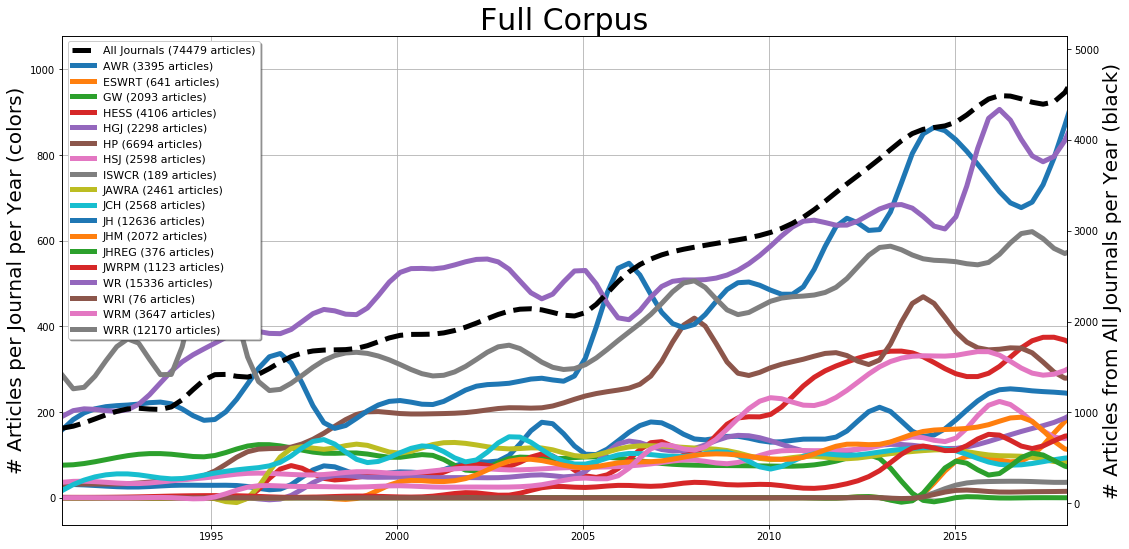

In [62]:
# Create corpus figure --- by year

# Init figures
fig, ax = plt.subplots(figsize=(18,9))


# # set color cycle
# colordexes = np.linspace(0,19,len(journals)).astype(int)
# colors = list(plt.cm.tab20(np.arange(20)))
# colors = [colors[i] for i in colordexes]
# ax.set_prop_cycle('color', colors)

#making an array of years in integer
years
years_int = []
for y in years:
    years_int.append(int(y))

years_int = np.array(years_int)

# Plot full corpus count by year
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
cd = np.sum(corpus_distribution, axis=0)
xnew = np.linspace(years_int.min(), years_int.max(), 100)
spl = make_interp_spline(years, cd, k = 3)
power_smooth = spl(xnew)
lines = ax2.plot(xnew, power_smooth, 
                 'k--', 
                 label=f'All Journals ({np.sum(corpus_distribution).astype(int)} articles)', 
                 linewidth = 5)  

# Plot each journal individually
for j, journal in enumerate(journals):
    cd = corpus_distribution[j,:]
    xnew = np.linspace(years_int.min(), years_int.max(), 100)
    spl = make_interp_spline(years, cd, k = 3)
    power_smooth = spl(xnew)
    linej = ax.plot(xnew, power_smooth, 
                       linewidth = 5,
                       label=f'{journal} ({np.sum(corpus_distribution[j,:]).astype(int)} articles)')
    lines = lines+linej

# Aesthetics    
ax.grid()   
# Axis labels
ax.set_title(f'Full Corpus', fontsize=30)
ax.set_ylabel('# Articles per Journal per Year (colors)', fontsize=20)
ax2.set_ylabel('# Articles from All Journals per Year (black)', fontsize=20)
ax.set_xlim([1991,2018])
ax2.set_xlim([1991,2018])

# ax.set_xticks(years_int[np.floor(np.linspace(0,len(years)-1,8)).astype(int)])
# ax.set_xticklabels(years[np.floor(np.linspace(0,len(years)-1,8)).astype(int)], fontsize=14)

#set legend
# ax0 = ax2.twinx()
# ax0 = fig.add_subplot()

labs = [l.get_label() for l in lines]
ax.legend(lines, labs, fontsize=11, shadow = True)

# Save figure
plt.savefig('figures/broad_corpus.png')

In [ ]:
# # Create corpus figure --- cumulative

# # Init figures
# fig, ax = plt.subplots(figsize=(12,6))

# # # set color cycle
# # colordexes = np.linspace(0,19,len(journals)).astype(int)
# # colors = list(plt.cm.tab20(np.arange(20)))
# # colors = [colors[i] for i in colordexes]
# # ax.set_prop_cycle('color', colors)

# # Plot full corpus count by year
# ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
# lines = ax2.plot(years, np.cumsum(np.sum(corpus_distribution, axis=0)), 
#                  'k--', 
#                  label=f'All Journals ({np.sum(corpus_distribution).astype(int)} articles)', 
#                  linewidth = 5)  

# # Plot each journal individually
# for j, journal in enumerate(journals):
#     linej = ax.plot(years, np.cumsum(corpus_distribution[j,:]), 
#                        linewidth = 5,
#                        label=f'{journal} ({np.sum(corpus_distribution[j,:]).astype(int)} articles)')
#     lines = lines+linej
    
# # Axis labels
# ax.set_title(f'Full Corpus', fontsize=20)
# ax.set_ylabel('# Articles per Journal (colors)', fontsize=16)
# ax2.set_ylabel('# Articles from All Journals (black)', fontsize=16)
# ax.set_xticks(years[np.floor(np.linspace(0,len(years)-1,8)).astype(int)])
# ax.set_xticklabels(years[np.floor(np.linspace(0,len(years)-1,8)).astype(int)], fontsize=14)

# # Legend
# labs = [l.get_label() for l in lines]
# ax.legend(lines, labs, fontsize=12)

# # Aesthetics    
# ax.grid()

# # Save figure
# plt.savefig('figures/full_corpus_cumulative.png')